In [1]:
import pandas as pd
import gtfs_kit as gk
import geopandas as gpd
import pyproj as pj
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
from folium import plugins
import warnings
import numpy as np
import helper #homemade function file helper.py

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

### Initial Exploration

In [2]:
# Load the gtfs we generated with the various csv file created in the preprocessing
feed = gk.feed.read_feed('../preprocessing.zip',dist_units="km")
routes = gk.routes.get_routes(feed)
stop_times = feed.get_stop_times()
trips = feed.get_trips()
stops = feed.get_stops()
shapes = feed.shapes
calendar_dates = feed.calendar_dates
calendar = feed.calendar

In [3]:
### Checking dimensions
routes_dimension = routes.shape
print(f" Routes Dimension: {routes.shape}")
trips_dimension = trips.shape
print(f" Trips Dimension: {trips.shape}")
stops_dimension = stops.shape
print(f" Stops Dimension: {stops.shape}")
stop_times_dimension = stop_times.shape
print(f" Stop Times Dimension: {stop_times.shape}")
shapes_dimension = shapes.shape
print(f" Shapes Dimension: {shapes.shape}")
calendar_dates_dimension = calendar_dates.shape
print(f" Calenda Dates Dimension: {calendar_dates.shape}")
calendar_dimension = calendar.shape
print(f" Calend Dimension: {calendar.shape}")

 Routes Dimension: (3, 7)
 Trips Dimension: (1201, 7)
 Stops Dimension: (36, 5)
 Stop Times Dimension: (12497, 6)
 Shapes Dimension: (104363, 5)
 Calenda Dates Dimension: (28260, 2)
 Calend Dimension: (201, 10)


In [4]:
### Look at the head of each table
print("Route Head of Dataframe")
print(routes.head())
print('-' * 50)
print("Trips Head of Dataframe")
print(trips.head())
print('-' * 50)
print("Stops Head of Dataframe")
print(stops.head())
print('-' * 50)
print("Stop Times Head of Dataframe")
print(stop_times.head())
print('-' * 50)
print("Shape Head of Dataframe")
print(shapes.head())
print('-' * 50)
print("Calendar Dates Head of Dataframe")
print(calendar_dates.head())
print('-' * 50)
print("Calendar Head of Dataframe")
print(calendar.head())

Route Head of Dataframe
     route_id agency_id route_short_name       route_long_name  route_type  \
0  1085727347       163              NaN  Pisa - Lucca - Aulla           2   
1  1199544473       163              NaN  Pisa - Lucca - Aulla           2   
2  1011259294       163              NaN  Pisa - Lucca - Aulla           2   

  route_color route_text_color  
0      FFFFFF           000000  
1      FFFFFF           000000  
2      FFFFFF           000000  
--------------------------------------------------
Trips Head of Dataframe
     route_id   service_id      trip_id trip_headsign trip_short_name  \
0  1085727347  1814_171965  1814_191301     Pisa C.Le           06772   
1  1085727347  1814_171965  1814_191302     Pisa C.Le           06732   
2  1085727347  1814_171965  1814_191303         Lucca           06745   
3  1085727347  1814_171965  1814_191304     Pisa C.Le           06794   
4  1085727347  1814_171965  1814_191305         Lucca           06733   

   direction_id  

### Adding information on the dataset

In [5]:
# We create an empty column for time different, speed, distance 
stop_times = stop_times.assign(time_diff=None)
stop_times = stop_times.assign(speed=None)
stop_times = stop_times.assign(dist_diff=None)

# Calculating Distance, Time and avg Speed between last stop and current stop
for index, row  in stop_times.iterrows():
    if row['stop_sequence'] == 1:
        stop_times['time_diff'][index] = 0
        stop_times['dist_diff'][index] = 0
        stop_times['speed'][index] = 0
    else:
        time = helper.get_sec(row['arrival_time']) - helper.get_sec(stop_times.loc[index - 1,'departure_time'])
        distance = row['shape_dist_traveled'] - stop_times.loc[index-1,'shape_dist_traveled']
        stop_times['time_diff'][index] = time
        stop_times['dist_diff'][index] = distance
        stop_times['speed'][index] = distance / (time / 3600) # Speed in km/h

In [6]:
stop_times.head(10)

trip_id arrival_time departure_time   stop_id  stop_sequence  \
0  1814_191301     15:42:00       15:42:00  S06404_1              1   
1  1814_191301     15:48:00       15:49:00  S06402_1              2   
2  1814_191301     15:56:00       15:57:00  S06400_1              3   
3  1814_191301     16:07:00       16:08:00  S06501_1              4   
4  1814_191301     16:13:00       16:13:00  S06500_1              5   
5  1814_191302     12:42:00       12:42:00  S06404_1              1   
6  1814_191302     12:48:00       12:49:00  S06402_1              2   
7  1814_191302     12:56:00       12:57:00  S06400_1              3   
8  1814_191302     13:07:00       13:08:00  S06501_1              4   
9  1814_191302     13:13:00       13:13:00  S06500_1              5   

   shape_dist_traveled time_diff      speed dist_diff  
0              0.00000         0          0         0  
1              8.01853       360    80.1853   8.01853  
2             14.83468       420  58.424143   6.81615  
3             20.90887       600   36.44514   6.07419  
4             23.13283       300   26.68752   2.22396  
5              0.00000         0          0         0  
6              8.01853       360    80.1853   8.01853  
7             14.83468       420  58.424143   6.81615  
8             20.90887       600   36.44514   6.07419  
9             23.13283       300   26.68752   2.22396

### Plotting our root

In [7]:
### Our dataframe contains geographical coordinates and we convert them 
### in GeoDataFrame for better visualization
shapes = gpd.GeoDataFrame(shapes, 
        geometry=gpd.points_from_xy(shapes.shape_pt_lon, shapes.shape_pt_lat)).set_crs(epsg=4326)

stops = gpd.GeoDataFrame(stops, 
        geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat)).set_crs(epsg=4326)

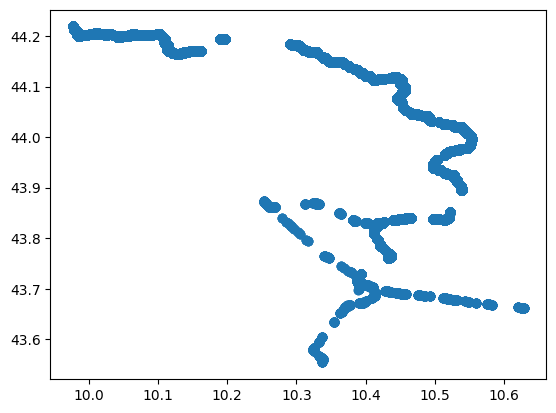

In [8]:
### We plot the shape which will result as the route
rt_df = pd.merge(routes, trips, on=['route_id','route_id']).reset_index(drop=True)
rts_df = pd.merge(rt_df, shapes, on=['shape_id','shape_id']).reset_index(drop=True)
plt.scatter(rts_df.shape_pt_lon, rts_df.shape_pt_lat)
#plt.savefig('./route_plot.png')
plt.show()

In [9]:
### We visualize the route to understand if there are impurities
helper.route_and_stop_visualization(stops,shapes)

## Data cleaning

In [10]:
stops

stop_id         stop_name   stop_lat   stop_lon stop_code  \
0   S06404_1             Lucca  43.837397  10.506153    S06404   
1   S06402_1        Ripafratta  43.821737  10.415844    S06402   
2   S06400_1  S.Giuliano Terme  43.764855  10.436916    S06400   
3   S06501_1    Pisa S.Rossore  43.723446  10.387754    S06501   
4   S06500_1         Pisa C.Le  43.708231  10.398389    S06500   
5   S06401_1            Rigoli  43.789761  10.419810    S06401   
6   S06502_1         Navacchio  43.686018  10.487235    S06502   
7   S06504_1   S.Frediano A S.  43.680915  10.516213    S06504   
8   S06505_1           Cascina  43.674657  10.545433    S06505   
9   S06506_1    Pontedera C.T.  43.662342  10.628906    S06506   
10  S06725_1      Livorno C.Le  43.554213  10.336400    S06725   
11  S06313_1   S.Pietro A Vico  43.875088  10.531057    S06313   
12  S06312_1   Ponte A Moriano  43.908382  10.534134    S06312   
13  S06310_1  Diecimo-Pescagl.  43.959490  10.507770    S06310   
14  S06309_1   Borgo A Mozzano  43.977306  10.541280    S06309   
15  S06308_1    Bagni Di Lucca  44.003472  10.551756    S06308   
16  S06306_1   Ghivizzano-Cor.  44.027720  10.510281    S06306   
17  S06304_1  Fornaci Di Barga  44.045026  10.474285    S06304   
18  S06303_1   Barga-Gallicano  44.068124  10.452101    S06303   
19  S06302_1  Castelvecchio P.  44.090181  10.455058    S06302   
20  S06301_1  Fosciandora-Ces.  44.118664  10.444314    S06301   
21  S06300_1  Castelnuovo Gar.  44.116437  10.409185    S06300   
22  S06322_1  Villetta S. Rom.  44.146900  10.367699    S06322   
23  S06323_1  Poggio-Car.-Vag.  44.148485  10.350640    S06323   
24  S06324_1       Camporgiano  44.161474  10.334720    S06324   
25  S06325_1  Piazza Al Serch.  44.182691  10.296700    S06325   
26  S06227_1  Minucciano P. C.  44.194342  10.193815    S06227   
27  S06226_1        Equi Terme  44.170239  10.153647    S06226   
28  S06225_1           Monzone  44.165774  10.123858    S06225   
29  S06224_1          Gragnola  44.191163  10.109104    S06224   
30  S06223_1   Fivizzano-Gass.  44.202877  10.091659    S06223   
31  S06222_1  F.Rometta-Solie.  44.202293  10.061017    S06222   
32  S06013_1   Aulla Lunigiana  44.218878   9.976878    S06013   
33  S06040_1         Viareggio  43.873954  10.252689    S06040   
34  S06350_1  Massarosa Bozzan  43.859161  10.346156    S06350   
35  S06351_1           Nozzano  43.829912  10.407130    S06351   

                     geometry  
0   POINT (10.50615 43.83740)  
1   POINT (10.41584 43.82174)  
2   POINT (10.43692 43.76485)  
3   POINT (10.38775 43.72345)  
4   POINT (10.39839 43.70823)  
5   POINT (10.41981 43.78976)  
6   POINT (10.48724 43.68602)  
7   POINT (10.51621 43.68091)  
8   POINT (10.54543 43.67466)  
9   POINT (10.62891 43.66234)  
10  POINT (10.33640 43.55421)  
11  POINT (10.53106 43.87509)  
12  POINT (10.53413 43.90838)  
13  POINT (10.50777 43.95949)  
14  POINT (10.54128 43.97731)  
15  POINT (10.55176 44.00347)  
16  POINT (10.51028 44.02772)  
17  POINT (10.47429 44.04503)  
18  POINT (10.45210 44.06812)  
19  POINT (10.45506 44.09018)  
20  POINT (10.44431 44.11866)  
21  POINT (10.40918 44.11644)  
22  POINT (10.36770 44.14690)  
23  POINT (10.35064 44.14848)  
24  POINT (10.33472 44.16147)  
25  POINT (10.29670 44.18269)  
26  POINT (10.19382 44.19434)  
27  POINT (10.15365 44.17024)  
28  POINT (10.12386 44.16577)  
29  POINT (10.10910 44.19116)  
30  POINT (10.09166 44.20288)  
31  POINT (10.06102 44.20229)  
32   POINT (9.97688 44.21888)  
33  POINT (10.25269 43.87395)  
34  POINT (10.34616 43.85916)  
35  POINT (10.40713 43.82991)

In [11]:
# Delete the stops not delonging to our railway line 
stops_id_to_delete = ["S06725_1","S06506_1","S06505_1","S06504_1","S06502_1","S06351_1","S06350_1","S06040_1"]
for stops_to_delete in stops_id_to_delete:
    stops = stops[stops.stop_id != stops_to_delete]

In [12]:
stops.shape

(28, 6)

In [13]:
# Based on the stops we calculate the list of stop_times to delete. We also take the list of
# trip ids to delete

trip_ids_to_delete = []
indexes_stops_to_delete = []
for ind in stop_times.index:
    for stops_to_delete in stops_id_to_delete:
        if stop_times["stop_id"][ind] == stops_to_delete:
            trip_ids_to_delete.append(stop_times["trip_id"][ind])
            indexes_stops_to_delete.append(ind)


### For safety reasons we delete rows from the dataframe after we calculate the speed in the 
for ind_to_delete in indexes_stops_to_delete:
    stop_times = stop_times[stop_times.index != ind_to_delete]

In [14]:
# Based on the trips_ids we calculate the list of shapes and trips to delete. 

shape_ids_to_delete = []

for ind in trips.index:
    for trip_to_delete in trip_ids_to_delete:
        if trips["trip_id"][ind] == trip_to_delete:
            shape_ids_to_delete.append(trips["shape_id"][ind])

### For safety reasons we delete rows from the dataframe after the complete for sequence
for trip_to_delete in trip_ids_to_delete:
    trips = trips[trips.trip_id != trip_to_delete]
    
## We do deletion for shapes too
for shape_to_delete in shape_ids_to_delete:
    shapes = shapes[shapes.shape_id != shape_to_delete]

In [15]:
### We visualize the route after the cleaning
helper.route_and_stop_visualization(stops,shapes)

In [16]:
# Subtraction of dimensions
subtracted_dimensions = pd.DataFrame(columns=["Name","Initial","Updated","Difference"])

res = tuple(map(lambda i, j: i - j, stops_dimension, stops.shape))
subtracted_dimensions.loc[0] = ["Stops",stops_dimension, stops.shape, res]

res = tuple(map(lambda i, j: i - j, trips_dimension, trips.shape))
subtracted_dimensions.loc[1] = ["Trips",trips_dimension, trips.shape, res]

res = tuple(map(lambda i, j: i - j, stop_times_dimension,stop_times.shape))
subtracted_dimensions.loc[2] = ["Stop_Times",stop_times_dimension, stop_times.shape, res]

res = tuple(map(lambda i, j: i - j, shapes_dimension, shapes.shape))
subtracted_dimensions.loc[3] = ["Shapes",shapes_dimension, shapes.shape, res]

subtracted_dimensions

Name      Initial     Updated  Difference
0       Stops      (36, 5)     (28, 6)     (8, -1)
1       Trips    (1201, 7)   (1149, 7)     (52, 0)
2  Stop_Times   (12497, 6)  (12393, 9)   (104, -3)
3      Shapes  (104363, 5)  (96692, 6)  (7671, -1)

## Saving general data processed

In [17]:
#Load the previous zip for setup
result = gk.feed.read_feed('../preprocessing.zip',dist_units="km")

#Overwrite modified tables
result.routes = routes
result.stop_times = stop_times
result.trips = trips
result.stops = stops
result.shapes = shapes
result.calendar_dates = calendar_dates
result.calendar = calendar

#Write
result.write('../general_data_analytics.zip',9)

## Basic summary stats


In [18]:
# Join the dataset for easy at use
df_analytics = trips
df_analytics = pd.merge(df_analytics, routes, on=['route_id','route_id'])
df_analytics = pd.merge(df_analytics, stop_times, on=['trip_id','trip_id'])
df_analytics = pd.merge(df_analytics, stops, on=['stop_id','stop_id'])


Mean of stop_sequence : 8.214128595600677
--------------------------------------------------
Median of stop_sequence : 6.0
--------------------------------------------------
Standard Deviation of stop_sequence : 6.3794942916546935
--------------------------------------------------
Skewness of stop_sequence : 0.8484014908177951


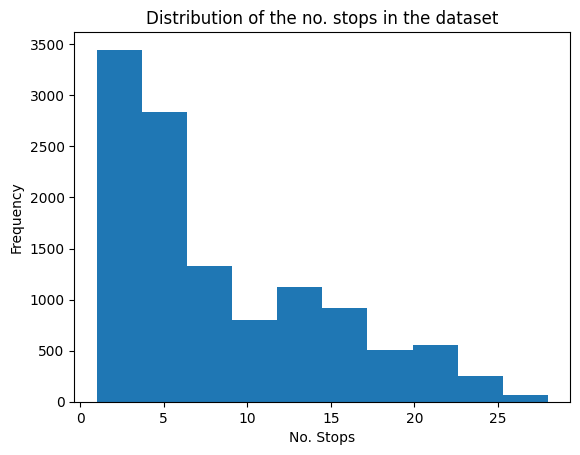

In [19]:
# Basic statistics on the number of stops and
# Distribution of number of stops in the dataset
helper.stop_sequence_statistics(df_analytics)

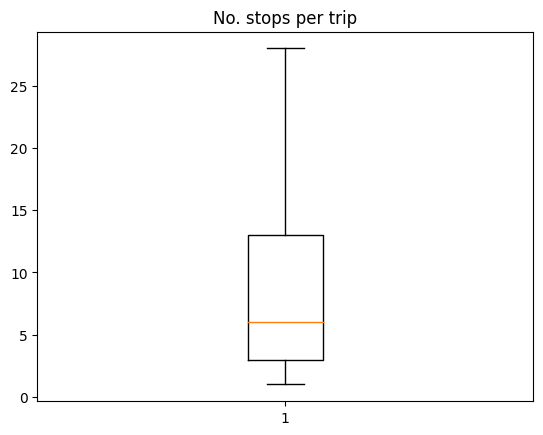

In [20]:
# Number of stops per trip
helper.boxplot_stop_sequence(df_analytics)

In [21]:
# For more precision of calculations we don't consider in the analysis the start stop 
# where speed, time , distance are all equal to 0
df_analytics.drop(df_analytics[(df_analytics['time_diff'] == 0) & 
                              (df_analytics['dist_diff'] == 0) &
                              (df_analytics['speed'] == 0)].index, inplace=True)

Mean of time difference : 340.52853528254144
--------------------------------------------------
Median of time difference : 300.0
--------------------------------------------------
Standard Deviation of time difference : 149.6167609919718
--------------------------------------------------
Skewness of time difference : 1.241954169396384
--------------------------------------------------


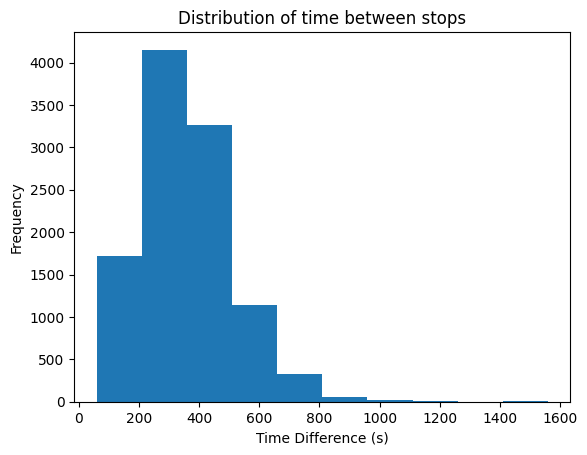

In [22]:
# Basic statistics for time
helper.time_statistics(df_analytics)

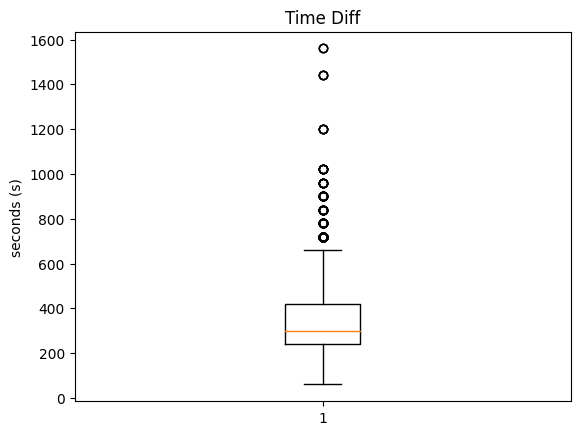

In [23]:
# Box plot on time difference
helper.boxplot_time(df_analytics)

Mean of distance difference : 4.9428847802452704
--------------------------------------------------
Median of distance difference : 4.1336200000000005
--------------------------------------------------
Standard Deviation of distance difference : 2.3719169617064204
--------------------------------------------------
Skewness of distance difference : 1.2078851592042403
--------------------------------------------------


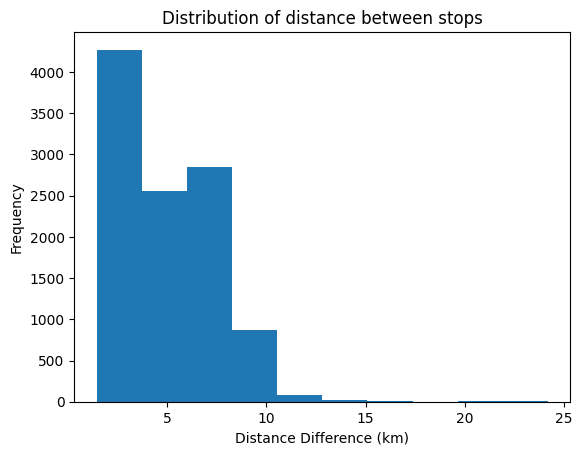

In [24]:
# Basic statistics for distance
helper.distance_statistics(df_analytics)

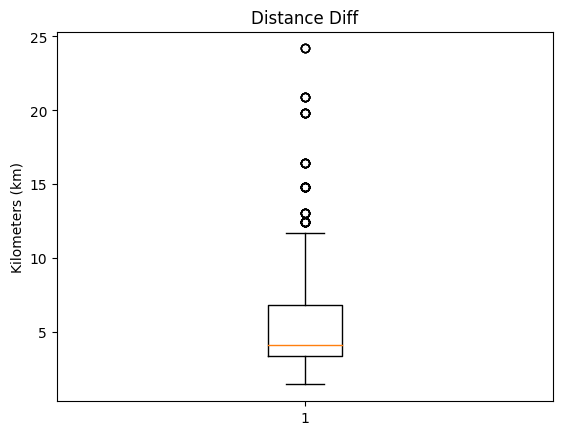

In [25]:
# Box plot on distance difference
helper.boxplot_distance(df_analytics)

Mean of speed : 53.51958283344214
--------------------------------------------------
Median of speed : 52.339439999999996
--------------------------------------------------
Standard Deviation of speed : 14.850400804106979
--------------------------------------------------
Skewness of speed : 0.0009837747318610613
--------------------------------------------------


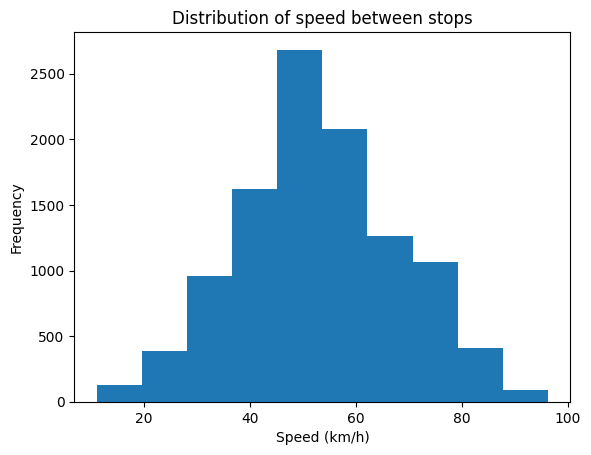

In [26]:
# Basic statistics for speed
helper.speed_statistics(df_analytics)

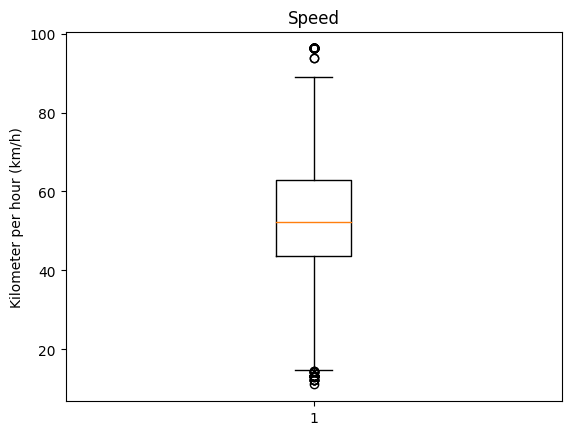

In [27]:
# Number of speed per trip
helper.boxplot_speed(df_analytics)

In [28]:
### TODO
    # Plot the spatial distribution of speed variable at each stop

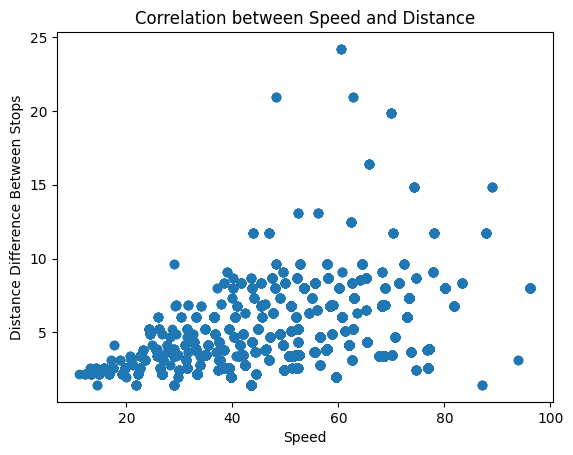

In [29]:
# Correlation between Speed and Distance
helper.scatter_speed_distance(df_analytics)

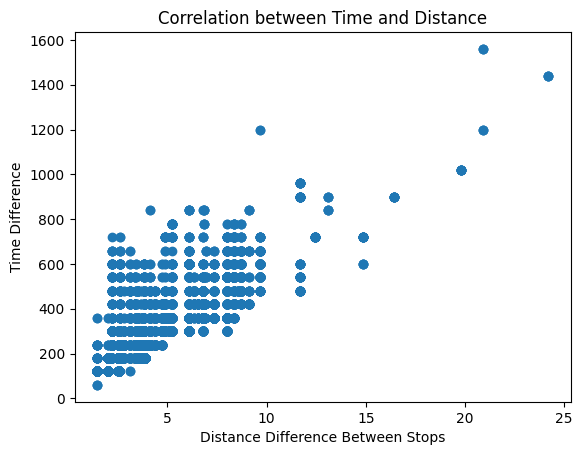

In [30]:
# Correlation between Time and Distance
helper.scatter_time_distance(df_analytics)

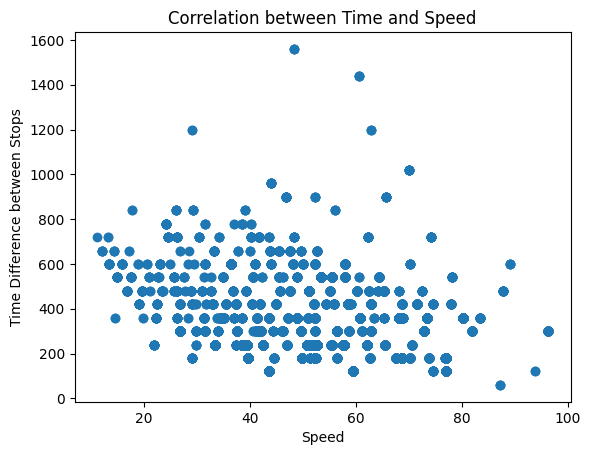

In [31]:
# Correlation between Time and Speed
helper.scatter_time_speed(df_analytics)

For each value:
    last_stop_sequence  value
0                    2      0
1                    3      6
2                    4     16
3                    5    563
4                    6     93
5                    7     16
6                    8     48
7                    9      8
8                   10      0
9                   11      6
10                  12      6
11                  13     46
12                  14     14
13                  15     31
14                  16      6
15                  17     21
16                  18     32
17                  19      6
18                  20     56
19                  21     24
20                  22     43
21                  23     26
22                  24     25
23                  25     17
24                  26     24
25                  27      8
26                  28      8
27                  29      0
--------------------------------------------------


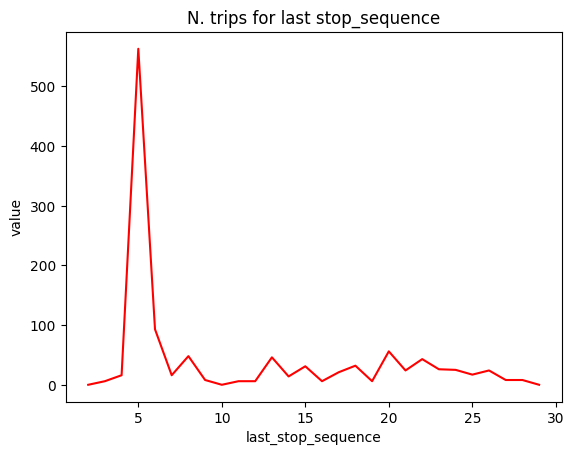

In [32]:
result = helper.plot_number_stops(df_analytics)

In [33]:
helper.aggregated_number_stops(result,3)

   last_stop_sequence  value
0              (0, 3]      6
1              (3, 6]    672
2              (6, 9]     72
3             (9, 12]     12
4            (12, 15]     91
5            (15, 18]     59
6            (18, 21]     86
7            (21, 24]     94
8            (24, 27]     49
9            (27, 30]      8
10           (30, 33]      0
